# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

# Preprocessing 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import seaborn as sns
import warnings
import progressbar

warnings.filterwarnings("ignore")
sns.set()
bar = progressbar.ProgressBar(maxval=100, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

* Loading Data from sql database. Ignored neutral reviews that is score=3. And data is sorted according to time.

In [2]:
import sqlite3

conn = sqlite3.connect('Data/database.sqlite')

data = pd.read_sql_query("select * from Reviews", conn)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Deduplication


* Same review from a user to a product in different time indicates duplicate data.
* Removed data that has same product ID, user id, score, text values.

In [3]:
# removing duplicates
data = data.drop_duplicates(subset={'ProductId', 'UserId', 'Score', 
                            'Text'}, keep='first')

### Data Cleaning

* Removed html tags, punctuations from each sentence.
* Each word is lowercased and removed stop words(a, an, the....).
* Removed stop words.

In [4]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

stop_words = set(stopwords.words('english'))
snow = SnowballStemmer('english')
pre_processed = []

i = 0
bar.maxval = len(data['Text'])
bar.start()
for sentence in data['Text']:    
    sentence = str(sentence)
    sentence = sentence.lower()
    clnr = re.compile('<.*?>') # for cleaning html tags
    sentence = re.sub(clnr, ' ', sentence)
    sentence = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]', r' ', sentence)
    sentence = re.sub('</br>', ' ', sentence) # br tag
    sentence = re.sub('\s+',' ', sentence)
    
    words = [snow.stem(word) for word in sentence.split() \
             if word not in stop_words]
    final_sentence = ''
    for word in words:
        final_sentence = final_sentence + word + ' '
    pre_processed.append(final_sentence)
    bar.update(i)
    i += 1

data['Text'] = pre_processed
bar.finish()

[========================================================================] 100%


### top features

* Trained tf-idf by on whole data and taken top most 2000 words by considering their tfidf value.
* TfidfVectorizer from sklearn is used.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_model = TfidfVectorizer()
tfidf_model.fit(data['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [6]:
# arranging vocabulary in order by their position
ind = list(tfidf_model.vocabulary_.values())
indices = np.array(ind).argsort()
te = list(tfidf_model.vocabulary_.keys())
vocabulary = np.array(te)[indices]

In [7]:
# arranging vocabulary in order by their idf value
indices = tfidf_model.idf_.argsort()
ordered_words = vocabulary[indices]

### Neighbourhood Matrix

* Constructing neighbourhood matrix in which each value represents the number of times did row and column word appeared in a neighbourhood.
* A distance of 2 words either left or right is considered as a neighbourhood.

In [8]:
num_top = 2000

# less idf(inverse....) => more important
top_words = ordered_words[0:num_top]
word_pos = {}
for i in range(num_top):
    word_pos[top_words[i]] = i

In [9]:
neigh_matrix = [[0 for i in range(num_top)] for j in range(num_top)]

i = 0
N = len(data['Text'])
for sentence in data['Text']:    
    sentence = str(sentence)
    words = sentence.split() 
    for j in range(len(words)):
        for k in [-2, -1, 1, 2]: # window size 5
            try:
                t1 = word_pos[words[j]]
                t2 = word_pos[words[j+k]]
                neigh_matrix[t1][t2] += 1 
            except:
                pass

## Truncated SVD

* Reducing dimension of matrix.
* Using TruncatedSVD function from sklearn.decomposition

In [10]:
from sklearn.decomposition import TruncatedSVD

variances = []
svd = TruncatedSVD(n_components=600)
svd.fit(neigh_matrix)

cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

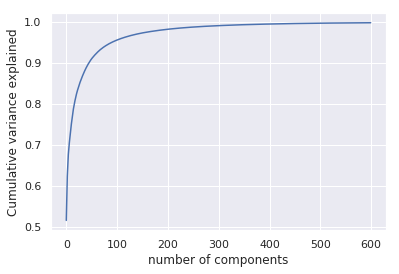

In [11]:
plt.clf()
plt.plot(cum_var_explained)
plt.axis('tight')
plt.xlabel('number of components')
plt.ylabel('Cumulative variance explained')
plt.show()

* Best value is 350.

In [12]:
svd = TruncatedSVD(n_components=350)
svd_data = svd.fit_transform(neigh_matrix)

# Clustering

* Clustering similar words by using 150 length representation of each word.
* Using KMeans algorithm for clustering.
* KMeans++ for cluster initialization.
* KMeans function from sklearn.cluster module.

In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, init='k-means++', max_iter=50)
kmeans.fit(svd_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
labels = kmeans.labels_
cluster_data = [[] for i in range(50)]

i = 0
for label in labels:
    cluster_data[label].append(top_words[i])
    i += 1

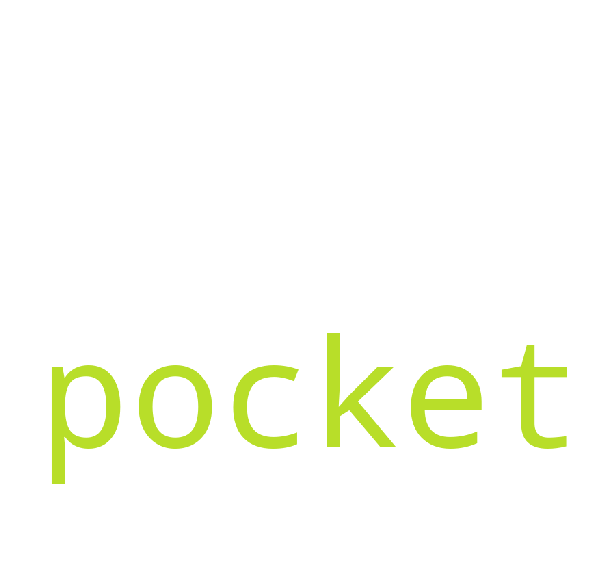

In [15]:
from wordcloud import WordCloud

# 1st cluster 
dt = ' '
for sen in cluster_data[0]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

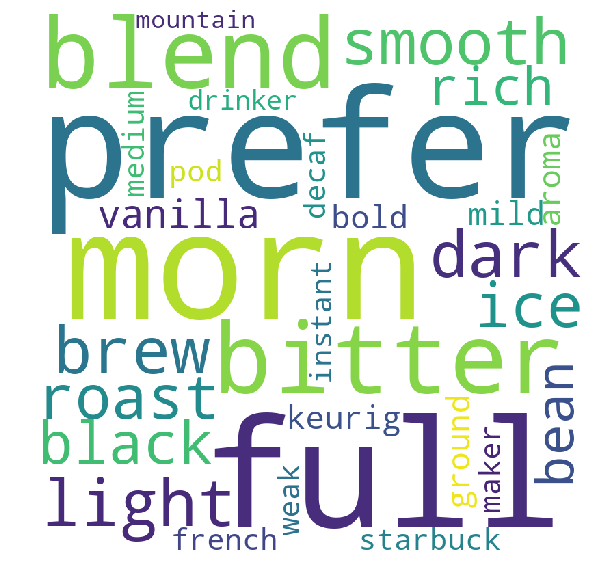

In [16]:
from wordcloud import WordCloud

# 4th cluster 
dt = ' '
for sen in cluster_data[3]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

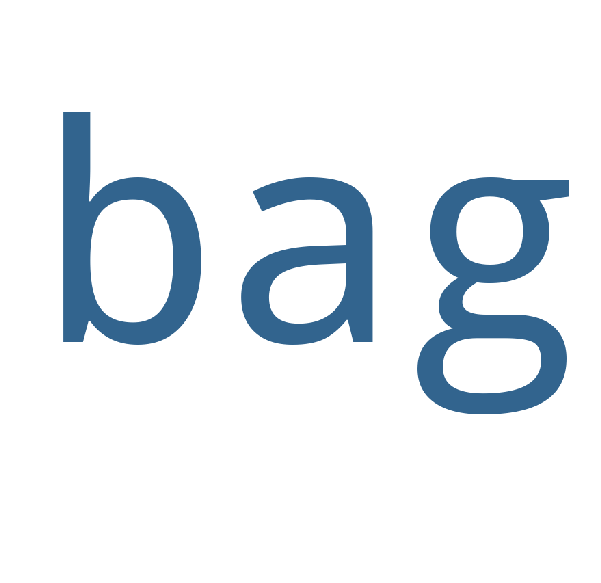

In [17]:
from wordcloud import WordCloud

# 2nd cluster 
dt = ' '
for sen in cluster_data[1]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

### top features

* Trained tf-idf by on whole data and taken top most 5000 words by considering their tfidf value.
* TfidfVectorizer from sklearn is used.

### Neighbourhood Matrix

* Constructing neighbourhood matrix in which each value represents the number of times did row and column word appeared in a neighbourhood.
* A distance of 2 words either left or right is considered as a neighbourhood.

In [18]:
num_top = 5000

# less idf(inverse....) => more important
top_words = ordered_words[0:num_top]
word_pos = {}
for i in range(num_top):
    word_pos[top_words[i]] = i

In [19]:
neigh_matrix = [[0 for i in range(num_top)] for j in range(num_top)]

i = 0
N = len(data['Text'])
for sentence in data['Text']:    
    sentence = str(sentence)
    words = sentence.split() 
    for j in range(len(words)):
        for k in [-2, -1, 1, 2]: # window size 5
            try:
                t1 = word_pos[words[j]]
                t2 = word_pos[words[j+k]]
                neigh_matrix[t1][t2] += 1
                neigh_matrix[t2][t1] += 1 
            except:
                pass

## Truncated SVD

* Reducing dimension of matrix.
* Using TruncatedSVD function from sklearn.decomposition

In [20]:
from sklearn.decomposition import TruncatedSVD

variances = []
svd = TruncatedSVD(n_components=1000)
svd.fit(neigh_matrix)

cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

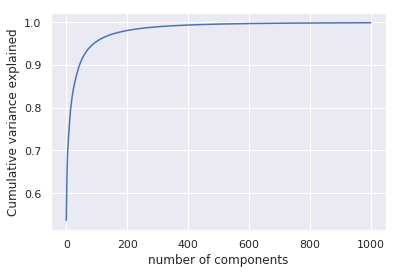

In [21]:
plt.clf()
plt.plot(cum_var_explained)
plt.axis('tight')
plt.xlabel('number of components')
plt.ylabel('Cumulative variance explained')
plt.show()

* Best value is 600.

In [22]:
svd = TruncatedSVD(n_components=600)
svd_data = svd.fit_transform(neigh_matrix)

# Clustering

* Clustering similar words by using 150 length representation of each word.
* Using KMeans algorithm for clustering.
* KMeans++ for cluster initialization.
* KMeans function from sklearn.cluster module.

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, init='k-means++', max_iter=100)
kmeans.fit(svd_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=50, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [24]:
labels = kmeans.labels_
cluster_data = [[] for i in range(50)]

i = 0
for label in labels:
    cluster_data[label].append(top_words[i])
    i += 1

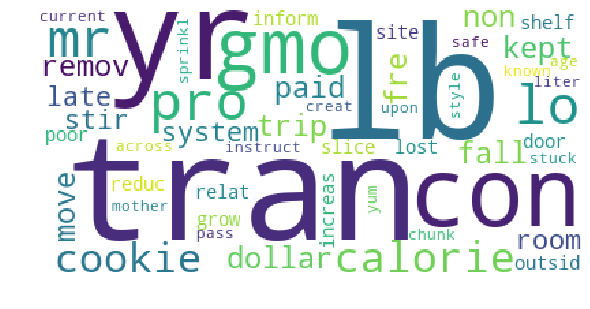

In [25]:
from wordcloud import WordCloud

# 1st cluster 
dt = ' '
for sen in cluster_data[0]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 400, height = 200, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

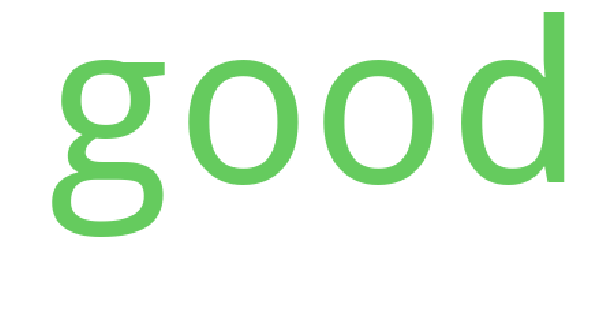

In [26]:
from wordcloud import WordCloud

# 4th cluster 
dt = ' '
for sen in cluster_data[3]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 400, height = 200, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

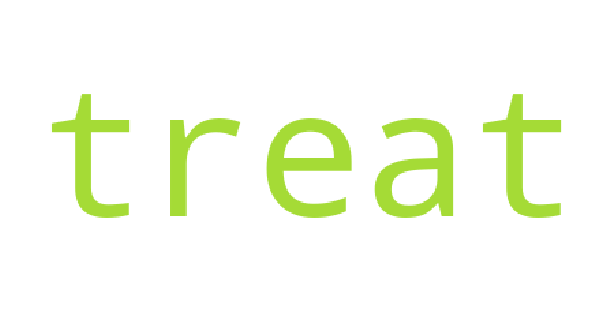

In [27]:
from wordcloud import WordCloud

# 2nd cluster 
dt = ' '
for sen in cluster_data[9]:
    dt = dt + sen + ' '

wordcloud = WordCloud(width = 400, height = 200, 
                background_color ='white',
                min_font_size = 10).generate(dt) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)
  
plt.show() 

In [45]:
def euclidian_distance(point1, point2):
    res = 0
    for i in range(len(point1)):
        res += ((point1[i] - point2[i]) ** 2)
    return res ** 0.5

In [49]:
def find_nearest(word):
    
    if word in top_words:
        for i in range(len(top_words)):
            if word == top_words[i]:
                ind = i
    else:
        print("This word not in vocabulary")
        
    distances = []
    for i in range(svd_data.shape[0]):
        distances.append(euclidian_distance(svd_data[i], svd_data[ind])) 
        
    sorted_indices = np.array(distances).argsort()
    for i in range(1, 10):
        print(top_words[sorted_indices[i]] + " " + str(distances[sorted_indices[i]]))
    

In [51]:
find_nearest("hi")

bravo 122.83736386392738
hello 123.461872980195
these 125.46348628701028
bc 125.84874656222007
sincer 127.55837266392558
outcom 128.88701785611772
astound 129.46066857786928
hat 130.37453591720256
spous 131.28971736893416


In [52]:
find_nearest("dollar")

00 1319.2648052821423
buck 1510.8855371183995
99 1517.3973763745853
retail 1949.8865664073287
walmart 1980.7266724601448
cent 1996.735016139771
discount 1999.3617532962965
target 2043.8373745500048
costco 2143.519468097766


In [54]:
find_nearest("trip")

drive 1605.920620953195
visit 1722.8029633937404
road 1723.306401682925
camp 1762.4321801130745
ran 1794.2569890402106
space 1798.6513831743578
vacat 1823.3329862492226
awhil 1830.5358254971563
specialti 1836.010661738095
